## Imports

In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, LogisticNormal
from torch.nn.parameter import Parameter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
%matplotlib inline

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    # SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)

%load_ext autoreload
%autoreload 2

In [2]:
use_gpu = False
# when set to True, it raises the following error in the model.train() cell...
# 
#     156         for flow in self.flows:
#     157             x, ld = flow.forward(x)
# --> 158             log_det += ld
#     159             zs.append(x)
#     160         return zs, log_det

# RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

device = torch.device(
        "cuda" if (torch.cuda.is_available() and use_gpu) else "cpu"
    )

# Introduction to Normalizing Flows



## Definition and basics 
Normalizing flows provide a general way of constructing flexible probability distributions over continuous random variables.

The main idea is to express $ \mathbf{x} \in \mathbb{R}^D $ as a transformation $T$ of a real vector $\mathbf{u}$ sampled from $p_\mathrm{u}(\mathbf{u})$, where $T$ must be *invertible* and both $T$ and $T^{-1}$ must be *differentiable*. Since $T$ is invertible, necessarily $\mathbf{u} \in \mathbb{R}^D$.

Under these conditions, the density of $\mathbf{x}$ is well-defined and can be written as $$p_\mathrm{x}(\mathbf{x}) = p_\mathrm{u}(\mathbf{u}) |\det J_T(\mathbf{u})|^{-1} = p_\mathrm{u}(T^{-1}(\mathbf{x})) |\det J_{T^{-1}}(\mathbf{x})| $$

In practice, $T$ ot $T^{-1}$ is implemented by a neural network and $p_\mathrm{u}(\mathbf{u})$ is taken to be a simple density such as a multivariate normal.

Intuitively, we can think of the transformation $T$ as expanding or contracting the space $\mathbb{R}^D$ in order to mold the density $p_\mathrm{u}(\mathbf{u})$ into $p_\mathrm{x}(\mathbf{x})$.

An important property of invertible and differentiable transformations is that they are *composable*. In practice, it is common to chain together multiple transformations $T_1, \dots, T_K$ to obtain $T = T_K \circ \dots \circ T_1 $.

The term 'normalizing' refers to the fact that the inverse flow through $T_K^{-1}, \dots, T_1^{-1}$ takes a collection of samples from $p_\mathrm{x}(\mathbf{x})$ and 'normalizes' them into a collection of samples from the prescribed density $p_\mathrm{u}(\mathbf{u})$.

In terms of functionality, a flow-based model provides two operations:
- sampling from the model using $\mathbf{x} = T(\mathbf{u})$
- evaluating the model's density using $p_\mathrm{x}(\mathbf{x}) = p_\mathrm{u}(T^{-1}(\mathbf{x})) |\det J_{T^{-1}}(\mathbf{x})| $

## Expressive power of flow-based models

Flow-based models can represent any distribution $ p_\mathrm{x}(\mathbf{x}) $ provided that those two conditions hold:
- $\forall \mathbf{x} \in \mathbb{R}^D,  p_x(\mathbf{x}) > 0$;
- All conditional probabilities $ \mathbb{P}_{\mathrm{x}_i^\prime}(\mathrm{x}_i^\prime \leq \mathrm{x}_i \mathrel{|} \mathbf{x}_{ < i}) $ are differentiable with respect to $ (\mathrm{x}_i, \mathbf{x}_{ < i}) $

## Using flows for modeling and inference

Fitting a flow-based model $p_\mathrm{x}(\mathbf{x}; \boldsymbol{\theta})$ to a target distribution $p_\mathrm{x}^*(\mathbf{x})$ can be done by minimizing some divergence between them w.r.t the model's parameters $\boldsymbol{\theta} = \{\phi, \psi\}$ where $\phi$ are the parameters of $T$ and $\psi$ the parameters of $p_\mathrm{u}(\mathbf{u})$.

### Forward KL divergence and Maximum Likelihood Estimation

The forward KL divergence is well-suited for situations in which we have samples from the target distribution (or the ability to generate them), but we cannot necessarily evaluate the target density $p_\mathrm{x}^*(\mathbf{x}) $.

The Forward KL Divergence between the target distribution $p_\mathrm{x}^*(\mathbf{x}) $ and the flow-based model $ p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) $ can be written as
$$ \begin{align} \mathcal{L}(\boldsymbol{\theta}) & = D_{\mathrm{KL} } [ p_\mathrm{x}^*(\mathbf{x}) \mathrel{\|} p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) ] \\ & =_+ - \mathbb{E}_{p_\mathrm{x}^*(\mathbf{x} ) } [ \log p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) ] \\ & =_+ - \mathbb{E}_{p_\mathrm{x}^*(\mathbf{x})} [ \log p_\mathrm{u}(T^{-1}(\mathbf{x} ; \phi) ; \psi) + \log | \det J_{T^{-1} }(\mathbf{x} ; \phi) | ] \end{align} $$
where $=_+$ means equal up to an additive constant.

Assuming we have a set of samples $\{\mathbf{x}_n\}_{n=1}^N$ from $p_\mathrm{x}^*(\mathbf{x}) $, we can estimate the expectation over $p_\mathrm{x}^*(\mathbf{x})$ by Monte-Carlo:

$$ \mathcal{L}(\boldsymbol{\theta}) \approx_+ - \frac{1}{N} \sum_{n=1}^N \log p_\mathrm{u}(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) + \log | \det J_{T^{-1} }(\mathbf{x}_n ; \phi) | $$

We typically optimize $ \boldsymbol{\theta}$ iteratively with stochastic gradient-based methods.

$$ \nabla_\phi \mathcal{L}(\mathbf{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\phi \log p_u(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) + \nabla_\phi \log | \det J_{T^{-1} }(\mathbf{x}_n ; \phi) | $$
$$ \nabla_\psi \mathcal{L}(\boldsymbol{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\psi \log p_u(T^{-1}(\mathbf{x}_n ; \phi) ; \psi) $$

In the case of Gaussian distributions, the update w.r.t $\psi = \{ \mu, \sigma \}$ may be done in closed form:
$$ \mu = \frac{1}{N} \sum_{n=1}^N T^{-1}(\mathbf{x}_n ; \phi) $$
$$ \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N (T^{-1}(\mathbf{x}_n ; \phi) - \mu)^2} $$

### Reverse KL divergence

The reverse KL divergence is suitable when we can evaluate $ p_x^*(\mathbf{x}) $ but not necessarily sample from it.

The Reverse KL Divergence between the target distribution $ p_x^*(\mathbf{x}) $ and the flow-based model $ p_x(\mathbf{x} ; \boldsymbol{\theta}) $ can be written as
$$ \begin{align} \mathcal{L}(\boldsymbol{\theta}) & = D_{\mathrm{KL} } [ p_\mathrm{x}(\mathbf{x} ; \boldsymbol{\theta}) \mathrel{\|} p_x^*(\mathbf{x}) ] \\ & = \mathbb{E}_{p_x(\mathbf{x} ; \boldsymbol{\theta}) } [ \log p_x(\mathbf{x} ; \boldsymbol{\theta}) - \log p_x^*(\mathbf{x}) ] \\ & = \mathbb{E}_{p_u(\mathbf{u} ; \psi)} [ \log p_u(\mathbf{u} ; \psi) - \log | \det J_{T}(\mathbf{u} ; \phi) | - \log p_x^*(T(\mathbf{u} ; \phi) ) ] \end{align} $$

In fact, we can minimize $ \mathcal{L}(\boldsymbol{\theta}) $ even if we can only evaluate $ p_x^*(\mathbf{x}) $ up to a multiplicative normalizing constant $ C $: we may assume that $ p_x^*(\mathbf{x}) = \tilde{p}_x(\mathbf{x}) / C $ where $ \tilde{p}_x(\mathbf{x}) $ is tractable.

We then minimize $\mathcal{L}(\boldsymbol{\theta})$ with stochastic gradient-based methods in practice. Since we reparameterized the expectation to be w.r.t. the base distribution $p_\mathrm{u}(\mathbf{u}; \psi)$, we can easily obtain an unbiased estimate of the gradient of $\mathcal{L}(\boldsymbol{\theta})$ w.r.t. $\phi$ by Monte-Carlo.

Let $\{\mathbf{u}_n\}_{n=1}^N$ be a set of samples from $p_\mathrm{u}(\mathbf{u}; \psi)$; the gradient of $\mathcal{L}(\boldsymbol{\theta})$ w.r.t $\phi$ can be estimated as follows:
$$ \nabla_\phi \mathcal{L}(\boldsymbol{\theta}) \approx -\frac{1}{N} \sum_{n=1}^N \nabla_\phi \log | \det J_T (\mathbf{u}_n ; \phi) | + \nabla_\phi \log \tilde{p}_x(T(\mathbf{u}_n ; \phi)) $$

We can then absorb the reparameterization $ T^\prime $ into $ T $ and replace the base distribution with $ p_{u^\prime} (\mathbf{u^\prime}) $ so we can assume without loss of generality that $ \psi $ is fixed.

### Duality between Forward and Reverse KL Divergence

Let $ p_u^*(\mathbf{u}, \phi) $ be the base distribution induced by the inverse flow $ T^{-1} $ from the target $ p_x^*(\mathbf{x}) $.
Then we have $$ D_\mathrm{KL} [ p_x^*(\mathbf{x}) \mathrel{\|} p_x(\mathbf{x} ; \boldsymbol{\theta}) ] = D_\mathrm{KL} [ p_u^*(\mathbf{u} ; \phi) \mathrel{\|} p_u(\mathbf{u} ; \psi) ] $$

This means that fitting the model to the target using the forward KL (maximum likelihood) is equivalent to fitting the induced distribution $ p_u^*(\mathbf{u} ; \phi) $ to the base $ p_u(\mathbf{u} ; \psi) $ under the reverse KL.

Reciprocally, there is also:

$$ D_\mathrm{KL} [ p_x(\mathbf{x} ; \boldsymbol{\theta}) \mathrel{\|} p_x^*(\mathbf{x}) ] = D_\mathrm{KL} [ p_u(\mathbf{u} ; \psi) \mathrel{\|} p_u^*(\mathbf{u} ; \phi) ] $$

## Target distribution $p_\mathrm{x}(\mathbf{x})$

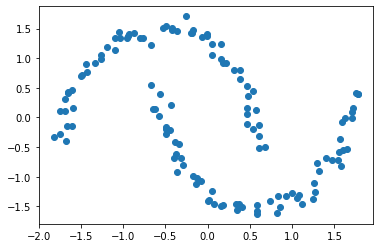

In [3]:
class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)
        
px = DatasetMoons()

X = px.sample(128)
X = StandardScaler().fit_transform(X)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Base distribution $p_\mathrm{u}(\mathbf{u})$

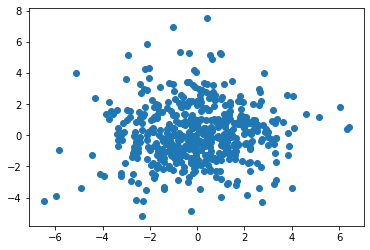

In [28]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
# base_dist = MultivariateNormal(base_mu, base_cov)
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution
U = prior.rsample(sample_shape=(512,))
plt.scatter(U[:, 0], U[:, 1])
plt.show()

# Constructing Flows Part I: Finite Compositions

We can construct a flow with transformation $T$ by composing a finite number of simple transformations $T_k$ as follows:
$$T = T_K \circ \dots \circ T_1$$
Assuming $\mathbf{z}_0 = \mathbf{u}$ and $\mathbf{z}_K = \mathbf{x}$, the forward evaluation is:
$$\mathbf{z}_k = T_k(\mathbf{z}_{k-1}) \quad \text{for } k=1:K$$
and the inverse evaluation is:
$$\mathbf{z}_{k-1} = T_k^{-1}(\mathbf{z}_{k}) \quad \text{for } k=K:1$$
and the Jacoboian-determinant computation is:
$$\log|J_T(\mathbf{z})| = \log \left|\prod_{k=1}^K J_{T_k}(\mathbf{z}_{k-1})\right| = \sum_{k=1}^K \log |J_{T_k}(\mathbf{z}_{k-1})|$$
Increasing the number of composed sub-flows of $T$ pleasantly only results in $\mathcal{O}(K)$ growth in computational cost.

We can implement either $T_k$ or $T_k^{-1}$ using a neural network of parameters $\phi_k$, which we will denote as $f_{\phi_k}$. In either case, we must ensure that the network is invertible and has a tractable Jacobian determinant. However, in many implementations, even though the inverse of $f_{\phi_k}$ is guaranteed to exist, it can be expensive or even intractable to compute exactly.

By 'tractable Jacobian determinant', we mean a Jacobian determinant whose computation should be at most $\mathcal{O}(D)$ (compared to $\mathcal{O}(D^3)$ in the general case).

To simplify notation from here on, we will drop the dependence of the network parameters on $k$ and denote the neural network by $f_\phi$, its input by $\mathbf{z}$ and its output by $\mathbf{z}^\prime$ regardless of whether the network is taken to implement $T_k$ or $T_k^{-1}$.

## Autoregressive flows
Autoregressive flows transform any distribution $ p_x(\mathbf{x}) $ into a uniform distribution in $(0,1)^D$ using maps with a triangular Jacobian.
$f_\phi$ has the following form:
$$ \mathrm{z}_i^\prime = \tau(\mathrm{z}_i; \boldsymbol{h}_i) \quad \text{where} \quad \boldsymbol{h}_i = c_i( \mathbf{z}_{ < i}) $$
$ \tau $ is called the transformer and $ c_i $ the $i$-th conditioner.
The transformer must be a strictly monotonic function of $ \mathrm{z}_i $, but the conditioner does not need to be a bijection.
The parameters $ \phi $ of $ f_\phi $ are typically the parameters of the conditioner, but sometimes the transformer has its own parameters too (in addition to $ \boldsymbol{h}_i $).

Autoregressive flows are *universal approximators* provided the transformer and the conditioner are flexible enough to represent any function arbitrary well.

### Implementing the Transformer

#### Affine autoregressive flows

$$ \tau (\mrm{z}_i, \bs{h}_i ) = \alpha_i \mrm{z}_i + \beta_i $$ where $ \bs{h}_i = \{ \tilde{\alpha}_i, \beta_i \} $ and $ \alpha_i = \exp(\tilde{\alpha}_i) $.
- Simple and analytically tractable, but limited expressiveness
- Unknown whether they are universal approximators even with multiple layers

In [59]:
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]
# flows = [AffineConstantFlow(dim=2) for i in range(9)]
model = NormalizingFlowModel(prior, flows).to(device)

In [60]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # TODO tune weight_decay
print("Number of params: {}".format(sum(p.numel() for p in model.parameters())))

Number of params: 22914


In [61]:
def train_model(model, optimizer, px, epochs=1000):
    model.train()
    for k in range(epochs):
        x = px.sample(128).to(device)
        
        zs, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob)  # negative log-likelihood

        model.zero_grad()
        loss.backward()
        optimizer.step()

        if k % 100 == 0:
            print(loss.item())

epochs = 1000
train_model(model, optimizer, px, epochs)

384.3441162109375
264.2769775390625
223.0333251953125
216.06207275390625
200.05657958984375
178.60926818847656
159.06210327148438
133.44503784179688
130.7493896484375
137.50112915039062


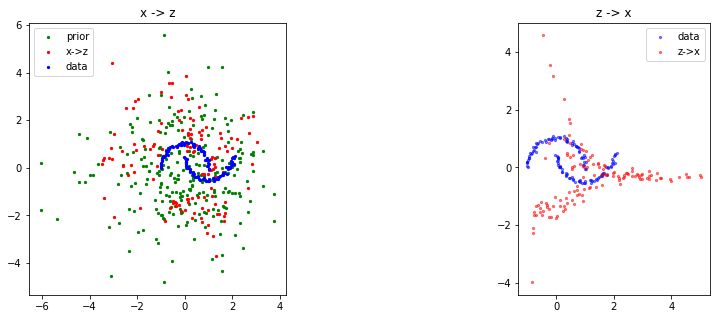

In [62]:
def eval_model(model, px, x_sample_size=128, z_sample_size=128):
    model.eval()

    sample_size = 128
    x = px.sample(x_sample_size)
    zs, prior_logprob, log_det = model(x)
    z = zs[-1]

    x = x.detach().numpy()
    z = z.detach().numpy()
    p = model.prior.sample([x_sample_size, 2]).squeeze()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.scatter(p[:,0], p[:,1], c='g', s=5)
    plt.scatter(z[:,0], z[:,1], c='r', s=5)
    plt.scatter(x[:,0], x[:,1], c='b', s=5)
    plt.legend(['prior', 'x->z', 'data'])
    plt.axis('scaled')
    plt.title('x -> z')

    zs = model.sample(z_sample_size)
    z = zs[-1]
    z = z.detach().numpy()
    plt.subplot(122)
    plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
    plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
    plt.legend(['data', 'z->x'])
    plt.axis('scaled')
    plt.title('z -> x')

    plt.show()

x_sample_size=128
z_sample_size=128
eval_model(model, px, x_sample_size, z_sample_size)

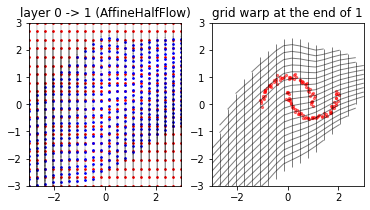

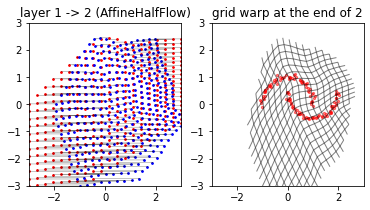

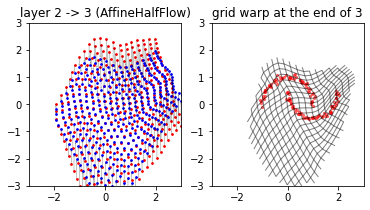

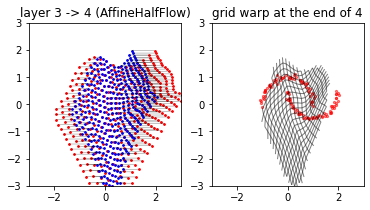

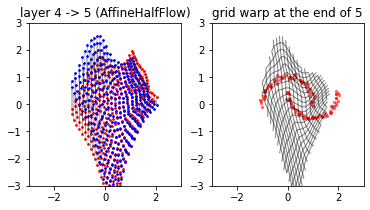

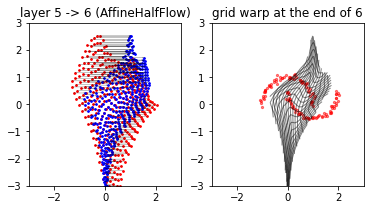

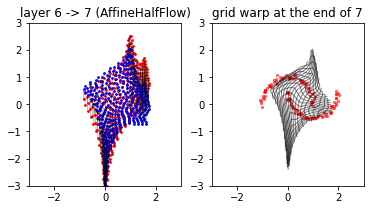

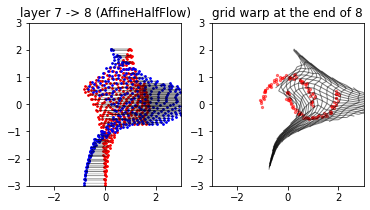

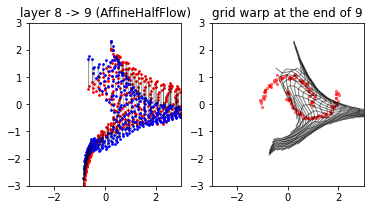

In [63]:
def visualize_model(model, ng=20):
    """ Visualize the step-wise flow in the full net """

    # plot the coordinate warp
    xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))

    zs, log_det = model.backward(xy)

    backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
    nz = len(zs)
    for i in range(nz - 1):
        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()
        
        # plot how the samples travel at this stage
        figs, axs = plt.subplots(1, 2, figsize=(6, 3))
        #plt.figure(figsize=(20,10))
        axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
        axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
        axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
        axs[0].axis([-3, 3, -3, 3])
        axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
        
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        axs[1].add_collection(lcy)
        axs[1].add_collection(lcx)
        axs[1].axis([-3, 3, -3, 3])
        axs[1].set_title("grid warp at the end of %d" % (i+1,))
        
        # draw the data too
        plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)

        plt.show()

ng = 20
visualize_model(model, ng=20)

# Sources and related work

## Repositories

- https://github.com/gebob19/introduction_to_normalizing_flows

- https://github.com/karpathy/pytorch-normalizing-flows

- https://github.com/fmu2/realNVP

- https://github.com/ikostrikov/pytorch-flows

- https://github.com/tonyduan/normalizing-flows

- https://github.com/chaiyujin/glow-pytorch

## Papers

- [Normalizing Flows for Probabilistic Modeling and Inference](https://arxiv.org/abs/1912.02762), Papamakarios et al., 2019

## Latex commands

$$
\newcommand{bb}[1]{\mathbb{#1}}
\newcommand{bs}[1]{\boldsymbol{#1}}
\newcommand{mbf}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{mrm}[1]{\mathrm{#1}}
\newcommand{mcal}[1]{\mathcal{#1}}
\newcommand{\eps}{\epsilon}
\newcommand{\veps}{\varepsilon}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\indep}{{\perp\!\!\!\!\perp}}
\newcommand{\bigo}{\mathcal{O}}
\newcommand{\del}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\ddel}[3]{\frac{\partial^{^{#3}}\! #1}{\partial#2^{^{#3}}}}
\newcommand{\diff}[2]{\frac{d #1}{d #2}}
\newcommand{\ddiff}[3]{\frac{d^{^{#3}}\! #1}{ d #2^{^{#3}}}}
\newcommand{\Diff}[2]{\frac{ \mathrm{d}#1}{\mathrm{d}#2}}
\newcommand{\DDiff}[3]{\frac{\mathrm{d}^{^{#3}}\! #1}{ \mathrm{d} #2^{^{#3}}}}
\newcommand{\dx}{\mathop{}\!d}
\newcommand{\ddx}[1]{\mathop{}\!d^#1}
\newcommand{\Dx}{\mathop{}\!\mathrm{d}}
\newcommand{\DDx}[1]{\mathop{}\!\mathrm{d^#1}}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\tr}{\mathrm{Tr}}
\newcommand{\cov}{\mathrm{Cov}}
$$